In [1]:
import os
import sys
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
import cv2 
import math
import random
from math import log
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['log', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def initialize_K_centroids(X, K):
    """ Choose K points from X at random """
    m = len(X)
    return X[np.random.choice(m, K, replace=False), :]

In [3]:
def find_closest_centroids(X, centroids):
    m = len(X)
    c = np.zeros(m)
    for i in range(m):
        # Find distances
        distances = np.linalg.norm(X[i] - centroids, axis=1)

        # Assign closest cluster to c[i]
        c[i] = np.argmin(distances)

    return c

In [4]:
def compute_means(X, idx, K):
    _, n = X.shape
    centroids = np.zeros((K, n))
    for k in range(K):
        examples = X[np.where(idx == k)]
        mean = [np.mean(column) for column in examples.T]
        centroids[k] = mean
    return centroids

In [5]:
def find_k_means(X, K, max_iters=10):
    centroids = initialize_K_centroids(X, K)
    previous_centroids = centroids
    for _ in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_means(X, idx, K)
        if (centroids == previous_centroids).all():
            # The centroids aren't moving anymore.
            return centroids
        else:
            previous_centroids = centroids

    return centroids, idx

In [6]:
try:
    image_path = "/content/drive/MyDrive/Major/images/Lenna.png"
    assert os.path.isfile(image_path)
except (IndexError, AssertionError):
    print('Please specify an image')

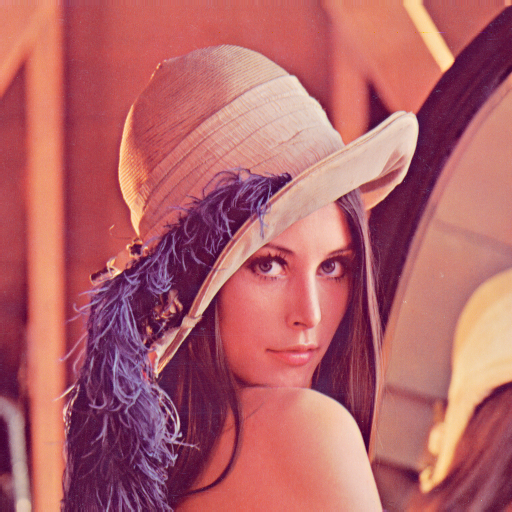

In [7]:
original_img = Image.open(image_path)
original_img

In [8]:
def load_image(path):
    """ Load image from path. Return a numpy array """
    image = original_img
    return np.asarray(image) / 255

In [9]:
image = load_image(original_img)
w, h, d = image.shape
print('Image found with width: {}, height: {}, depth: {}'.format(w, h, d))

Image found with width: 512, height: 512, depth: 3


In [10]:
X = image.reshape((w * h, d))
K = 20 # the desired number of colors in the compressed image

In [11]:
colors, _ = find_k_means(X, K, max_iters=20)

In [12]:
idx = find_closest_centroids(X, colors)

In [13]:
idx = np.array(idx, dtype=np.uint8)
X_reconstructed = np.array(colors[idx, :] * 255, dtype=np.uint8).reshape((w, h, d))
compressed_image = Image.fromarray(X_reconstructed)

In [28]:
compressed_image.save('lenna_out.png')

In [29]:
oi = image_path
ci = "lenna_out.png"

In [30]:
ogimg = BytesIO()
original_img.save(ogimg, "png")
crimg = BytesIO()
compressed_image.save(crimg, "png")

os = ogimg.tell()
cs = crimg.tell()
cr = os/cs

In [31]:
print(os, cs, cr)

479778 128784 3.725447260529258


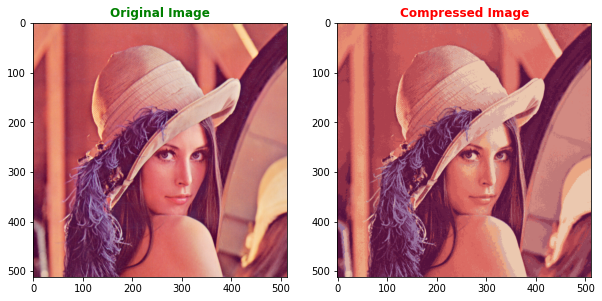

original image size
479778

compressed image size
128784

compression ratio
3.725447260529258


In [32]:
fig=plt.figure(figsize=(10, 10))

img = mpimg.imread(oi)
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image", color='green', fontweight="bold")

img = mpimg.imread(ci)
fig.add_subplot(1, 2, 2)
plt.imshow(img)
plt.title("Compressed Image", color='red', fontweight="bold")
plt.show()

print("original image size")
print(os) 
print("\ncompressed image size")
print(cs)
print("\ncompression ratio")
print(cr)

In [33]:
im = Image.open(ci)

In [34]:
def dec(bitSequence):
    decimal = 0
    for bit in bitSequence:
        decimal = decimal * 2 + int(bit)
    return decimal

In [35]:
def genHenonMap(dimension, key):
    x = key[0]
    y = key[1]
    sequenceSize = dimension * dimension * 8 #Total Number of bitSequence produced
    bitSequence = []    #Each bitSequence contains 8 bits
    byteArray = []      #Each byteArray contains m( i.e 512 in this case) bitSequence
    TImageMatrix = []   #Each TImageMatrix contains m*n byteArray( i.e 512 byteArray in this case)
    for i in range(sequenceSize):
        xN = y + 1 - 1.4 * x**2
        yN = 0.3 * x

        x = xN
        y = yN

        if xN <= 0.4:
            bit = 0
        else:
            bit = 1

        try:
            bitSequence.append(bit)
        except:
            bitSequence = [bit]

        if i % 8 == 7:
            decimal = dec(bitSequence)
            try:
                byteArray.append(decimal)
            except:
                byteArray = [decimal]
            bitSequence = []

        byteArraySize = dimension*8
        if i % byteArraySize == byteArraySize-1:
            try:
                TImageMatrix.append(byteArray)
            except:
                TImageMatrix = [byteArray]
            byteArray = []
    return TImageMatrix

In [36]:
#Encryption
def HenonEncryption(imageName,key):
    imageMatrix, dimension, color = getImageMatrix(imageName)
    transformationMatrix = genHenonMap(dimension, key)
    resultantMatrix = []
    for i in range(dimension):
        row = []
        for j in range(dimension):
            try:
                if color:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if color:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:    
            resultantMatrix.append(row)
        except:
            resultantMatrix = [row]
    if color:
      im = Image.new("RGB", (dimension, dimension))
    else: 
      im = Image.new("L", (dimension, dimension)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimension):
        for y in range(dimension):
            pix[x, y] = resultantMatrix[x][y]
    im.save(imageName.split('.')[0] + "_HenonEnc.png", "PNG")
    im.save("/content/drive/MyDrive/Major/images/encrypted/lenna_kmeans_HenonEnc.png", "PNG")

In [37]:
#Decryption
def HenonDecryption(imageNameEnc, key):
    imageMatrix, dimension, color = getImageMatrix(imageNameEnc)
    transformationMatrix = genHenonMap(dimension, key)
    pil_im = Image.open(imageNameEnc, 'r')
    imshow(np.asarray(pil_im))
    henonDecryptedImage = []
    for i in range(dimension):
        row = []
        for j in range(dimension):
            try:
                if color:
                    row.append(tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]))
                else:
                    row.append(transformationMatrix[i][j] ^ imageMatrix[i][j])
            except:
                if color:
                    row = [tuple([transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]])]
                else :
                    row = [transformationMatrix[i][j] ^ x for x in imageMatrix[i][j]]
        try:
            henonDecryptedImage.append(row)
        except:
            henonDecryptedImage = [row]
    if color:
        im = Image.new("RGB", (dimension, dimension))
    else: 
        im = Image.new("L", (dimension, dimension)) # L is for Black and white pixels

    pix = im.load()
    for x in range(dimension):
        for y in range(dimension):
            pix[x, y] = henonDecryptedImage[x][y]
    im.save(imageNameEnc.split('_')[0] + "_HenonDec.png", "PNG")
    im.save("/content/drive/MyDrive/Major/images/encrypted/lenna_kmeans_HenonDec.png", "PNG")

In [38]:
image = "lenna_out"
ext = ".png"
key = (0.1,0.1)

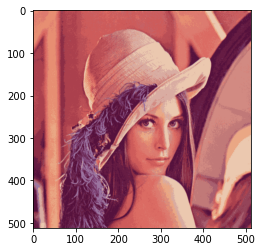

In [39]:
pil_im = Image.open(image + ext, 'r')
imshow(np.asarray(pil_im))

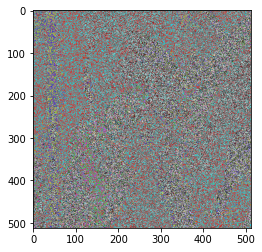

In [40]:
HenonEncryption(image + ext, key)
im = Image.open(image + "_HenonEnc.png", 'r')
imshow(np.asarray(im))

In [41]:
ei="/content/lenna_out_HenonEnc.png"

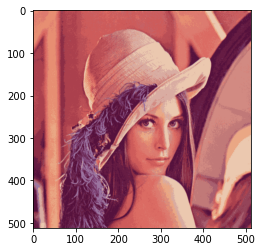

In [42]:
HenonDecryption(image + "_HenonEnc.png", key)

im = Image.open("/content/lenna_HenonDec.png", 'r')
imshow(np.asarray(im))

In [43]:
# Same as NPCR both are used for sensitivity analysis two encrypted image is required



# loc1="/content/drive/MyDrive/images/encrypted/imagedecrypt.png"
# loc2="/content/drive/MyDrive/images/Lenna.png"
uloc1 = ei
uloc2 = oi
def uaci(loc1,loc2):
    image1 = Image.open(loc1)
    image2 = Image.open(loc2)
    pixel1=image1.load()
    pixel2=image2.load()
    width,height=image1.size
    value=0.0
    for y in range(0,height):
        for x in range(0,width):
            value=(abs(pixel1[x,y][0]-pixel2[x,y][0])/255)+value

    value=(value/(width*height))*100
    return value
print("UACI")
print(uaci(uloc1,uloc2))

#decrypted image and original image

UACI
35.142259784784784


In [44]:
  # It has a NPCR(Number of pixel changed rate).It compares the pixel values of the original image and the encrypted image.
  # The resultant value is returned in percentage.If the value is more than 99% then the analysis is positive.
    
   # It consist of three modules rateofchange(),sumofpixel(),npcrv().


 #   This method compares two image.If the pixel value is same then 0 is stored in the matrix else one is stored
# loc1="/content/drive/MyDrive/images/encrypted/imagedecrypt.png"
# loc2="/content/drive/MyDrive/images/Lenna.png"
loc1 = ei
loc2 = oi
def rateofchange(height,width,pixel1,pixel2,matrix,i):

    for y in range(0,height):
        for x in range(0,width):
            #print(x,y)
            if pixel1[x,y][i] == pixel2[x,y][i]:
                matrix[x,y]=0
            else:
                matrix[x,y]=1
    return matrix
"""
    sum of the values of 1 stored in matrix is calculated
"""
def sumofpixel(height,width,pixel1,pixel2,ematrix,i):
    matrix=rateofchange(height,width,pixel1,pixel2,ematrix,i)
    psum=0
    for y in range(0,height):
        for x in range(0,width):
            psum=matrix[x,y]+psum
    return psum

"""
Finally the above two module is called to calculate the values
"""
def npcrv(loc1,loc2):
    c1 = Image.open(loc1)
    c2 = Image.open(loc2)
    width, height = c1.size
    pixel1 = c1.load()
    pixel2 = c2.load()
    ematrix = np.empty([width, height])
    per=(((sumofpixel(height,width,pixel1,pixel2,ematrix,0)/(height*width))*100)+((sumofpixel(height,width,pixel1,pixel2,ematrix,1)/(height*width))*100)+((sumofpixel(height,width,pixel1,pixel2,ematrix,2)/(height*width))*100))/3
    return per
print("NPCR")
print(npcrv(loc1,loc2))

NPCR
99.86623128255208


In [45]:
#calculating size of encrypted and decrypted files
encrypted_img = Image.open(ei)
decrypted_img = Image.open(ci)
enimg = BytesIO()
encrypted_img.save(enimg, "png")
deimg = BytesIO()
decrypted_img.save(deimg, "png")
es = enimg.tell()
ds = deimg.tell()

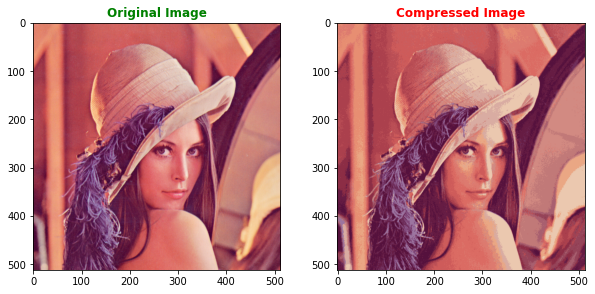

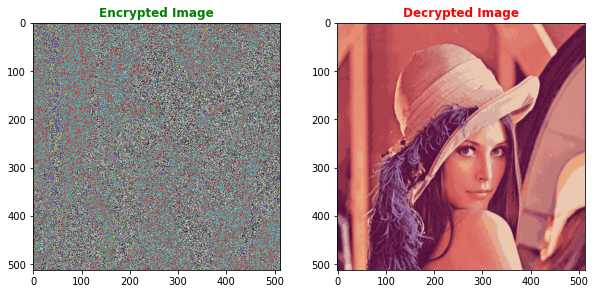

original image size
479778

compressed image size
128784

encrypted image size
756450

decrypted image size
128784

compression ratio
3.725447260529258

UACI
35.142259784784784

NPCR
99.86623128255208


In [46]:
fig=plt.figure(figsize=(10, 10))

img = mpimg.imread(oi)
fig.add_subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image", color='green', fontweight="bold")

img = mpimg.imread(ci)
fig.add_subplot(2, 2, 2)
plt.imshow(img)
plt.title("Compressed Image", color='red', fontweight="bold")
plt.show()

fig=plt.figure(figsize=(10, 10))

img = mpimg.imread(ei)
fig.add_subplot(2, 2, 3)
plt.imshow(img)
plt.title("Encrypted Image", color='green', fontweight="bold")

img = mpimg.imread(ci)
fig.add_subplot(2, 2, 4)
plt.imshow(img)
plt.title("Decrypted Image", color='red', fontweight="bold")
plt.show()

print("original image size")
print(os) 
print("\ncompressed image size")
print(cs)
print("\nencrypted image size")
print(es) 
print("\ndecrypted image size")
print(ds)
print("\ncompression ratio")
print(cr)
print("\nUACI")
print(uaci(uloc1,uloc2))
print("\nNPCR")
print(npcrv(loc1,loc2))